In [2]:
# Import necessary libraries
import os
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import genpareto
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

In [3]:
# Load the data
gdf = gpd.read_file('final_cleaned_gdf.geojson')

# Check for missing values
print(gdf.isnull().sum())

# Replace NaN values with 'No Spill'
gdf['root_cause'] = gdf['root_cause'].fillna('No Spill')

operator_number                0
flowline_id                    0
location_id                    0
status                         0
location_type                  0
fluid                          0
material                       0
diameter_in                    0
length_ft                      0
max_operating_pressure         0
shape_length                   0
line_age_yr                    0
root_cause                274652
risk                           0
geometry                       0
dtype: int64


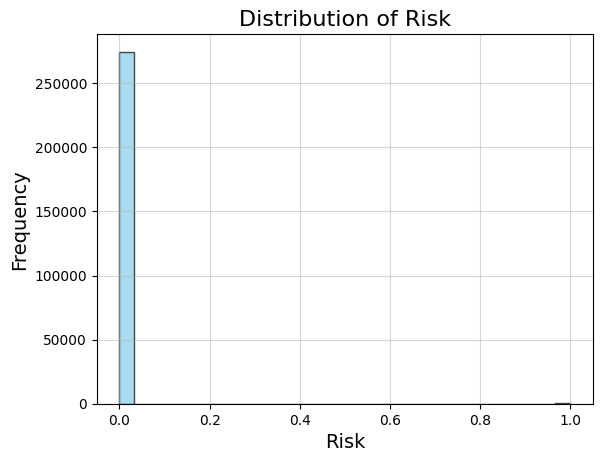

In [4]:
# Plot the distribution of the 'risk' column
plt.hist(gdf['risk'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    
# Add titles and labels
plt.title('Distribution of Risk', fontsize=16)
plt.xlabel('Risk', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, alpha=0.5)
    
# Show the plot
plt.show()

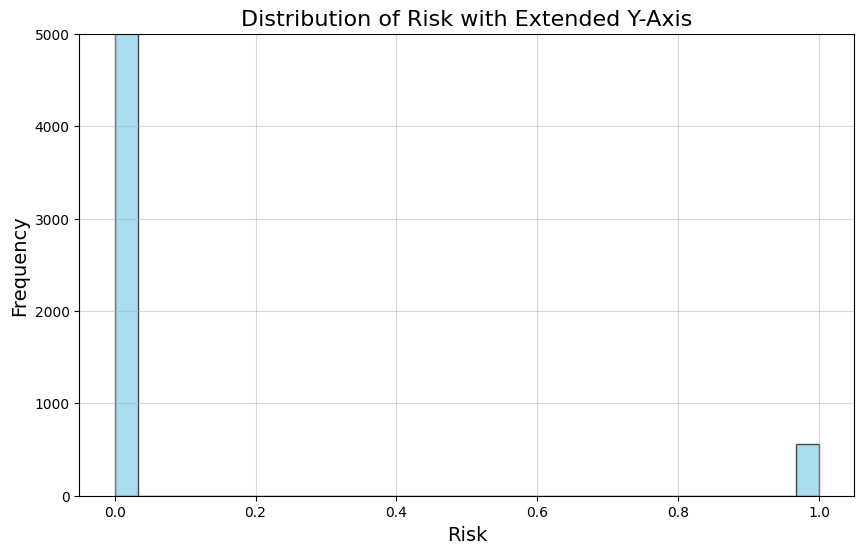

In [5]:
# Adjusting the y-axis to zoom in
plt.figure(figsize=(10, 6))

# Histogram of 'risk'
plt.hist(gdf['risk'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title('Distribution of Risk with Extended Y-Axis', fontsize=16)
plt.xlabel('Risk', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.ylim(0, 5000)  # Adjust the y-axis to highlight risk = 1
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

In [6]:
# Count the frequency of each unique value in the 'risk' column
if 'risk' in gdf.columns:
    risk_counts = gdf['risk'].value_counts()

    # Display the counts
    print("Counts of unique risk values:")
    print(risk_counts)
else:
    print("The 'risk' column is not found in the dataset.")

Counts of unique risk values:
risk
0    274652
1       562
Name: count, dtype: int64


In [7]:
print(gdf.columns)

Index(['operator_number', 'flowline_id', 'location_id', 'status',
       'location_type', 'fluid', 'material', 'diameter_in', 'length_ft',
       'max_operating_pressure', 'shape_length', 'line_age_yr', 'root_cause',
       'risk', 'geometry'],
      dtype='object')


In [8]:
# List of categorical variables
categorical_vars = ['status', 'location_type', 'fluid', 'material', 'root_cause', 'operator_number', 'flowline_id', 'location_id']
# List of numerical variables
numerical_vars = ['diameter_in', 'length_ft', 'max_operating_pressure',
                  'shape_length', 'line_age_yr']

# Perform one-hot encoding
gdf_encoded = pd.get_dummies(gdf, columns=categorical_vars, drop_first=True)

# Keep geometry for later use
gdf_geometry = gdf[['geometry']]

# Exclude geometry from the features
gdf_encoded = gdf_encoded.drop('geometry', axis=1)

# Define the feature matrix X and target vector y
X = gdf_encoded.drop('risk', axis=1)
y = gdf_encoded['risk']

# Standardize numerical features
scaler = StandardScaler()
X[numerical_vars] = scaler.fit_transform(X[numerical_vars])

# Similarity Matrix

In [9]:
# Subset of instances where risk = 1
X_risk1 = X[y == 1]

# Compute cosine similarity between all instances and risk = 1 instances
similarity_matrix = cosine_similarity(X, X_risk1)

# Average similarity scores for each instance
avg_similarity = similarity_matrix.mean(axis=1)

# Convert to a DataFrame
risk_scores = pd.DataFrame({
    'avg_similarity': avg_similarity
}, index=X.index)

In [10]:
# Normalize the risk scores
min_score = risk_scores['avg_similarity'].min()
max_score = risk_scores['avg_similarity'].max()

risk_scores['risk_probability'] = (
    risk_scores['avg_similarity'] - min_score
) / (max_score - min_score)

# Assign a risk probability of 1 to all risk = 1 instances
risk_scores.loc[y == 1, 'risk_probability'] = 1.0

In [11]:
#  gdf_result is the GeoDataFrame with risk probabilities
gdf_result = gdf.join(risk_scores['risk_probability'])

# Save the updated file

gdf_result.to_file('wo_pop_sim_result.geojson',driver='GeoJSON') 

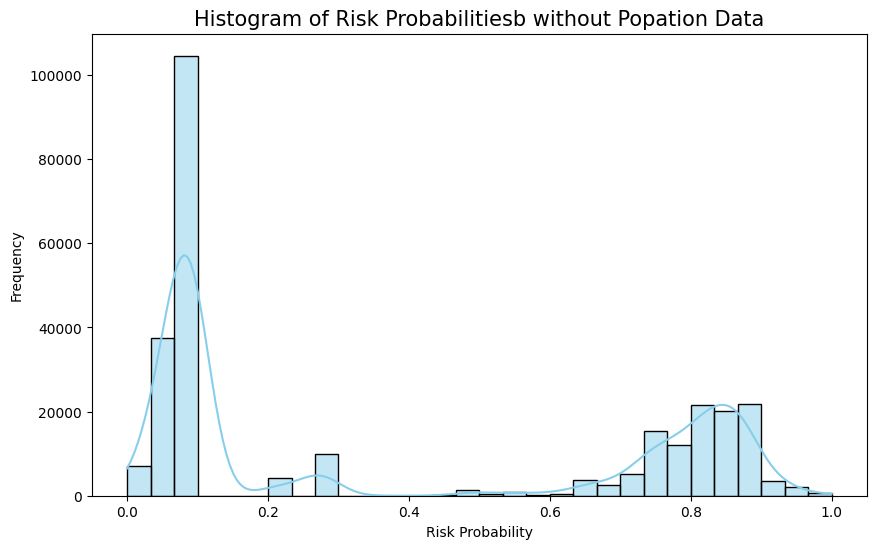

In [19]:
import seaborn as sns

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(gdf_result['risk_probability'], bins=30, kde=True, color='skyblue')

# Add labels and title
plt.title('Histogram of Risk Probabilitiesb without Popation Data', fontsize=15)
plt.xlabel('Risk Probability')
plt.ylabel('Frequency')

# Show the plot
plt.show()

/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_72996/1574042676.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r')


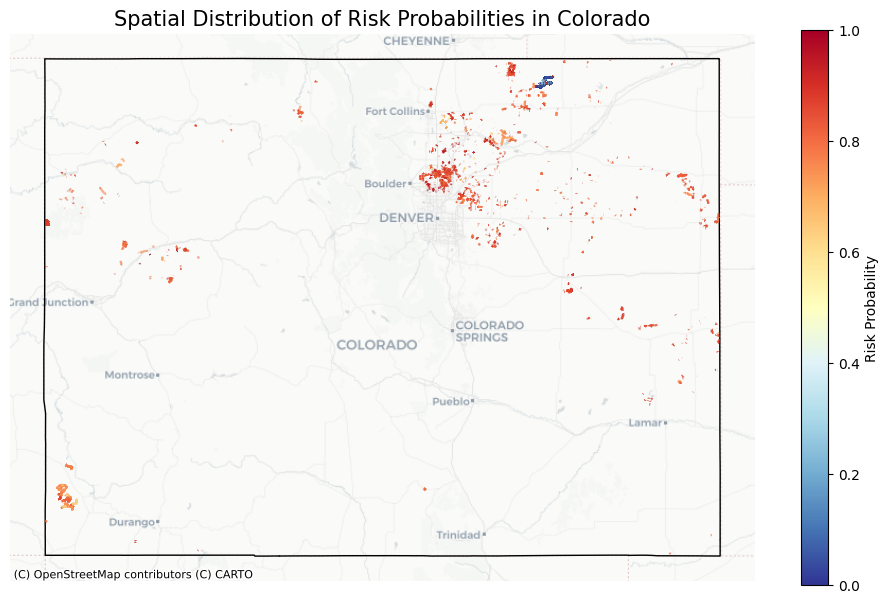

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # Import contextily for basemap

# Read Colorado state boundary
url = 'https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_500k.zip'
states = gpd.read_file(url)
colorado = states[states['NAME'] == 'Colorado']

# Ensure CRS matches
if gdf_result.crs != colorado.crs:
    gdf_result = gdf_result.to_crs(colorado.crs)

# Clip data to Colorado
gdf_colorado = gpd.clip(gdf_result, colorado)

# Reproject to Web Mercator (EPSG:3857) for contextily
gdf_colorado = gdf_colorado.to_crs(epsg=3857)
colorado = colorado.to_crs(epsg=3857)

# Use reversed 'RdYlBu' colormap which goes from blue to red
cmap = plt.cm.get_cmap('RdYlBu_r')

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot Colorado boundary
colorado.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot risk probabilities
gdf_colorado.plot(
    column='risk_probability',
    ax=ax,
    cmap=cmap,
    legend=True,
    legend_kwds={
        'label': "Risk Probability",
        'orientation': "vertical",
        'shrink': 0.6
    },
    alpha=0.7
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set title and remove axes
ax.set_title('Spatial Distribution of Risk Probabilities in Colorado', fontsize=15)
ax.set_axis_off()

# Show the plot
plt.show()

# Stats about Risk Probability

In [20]:
# Compute the mean feature vector of risk = 1 instances
X_risk1_mean = X_risk1.mean(axis=0)

In [21]:
from sklearn.preprocessing import normalize

# Convert to numpy arrays
X_array = X.values
X_risk1_mean_array = X_risk1_mean.values.reshape(1, -1)

# Normalize the feature vectors
X_normalized = normalize(X_array, axis=1)
X_risk1_mean_normalized = normalize(X_risk1_mean_array, axis=1)


In [22]:
import numpy as np

# Compute element-wise products (feature contributions)
feature_contributions = X_normalized * X_risk1_mean_normalized

# Sum over features to get similarity scores
similarity_scores = feature_contributions.sum(axis=1)

In [23]:
# Compute average contribution of each feature across all instances
average_feature_contributions = feature_contributions.mean(axis=0)

# Create a DataFrame with feature names and their average contributions
feature_contributions_df = pd.DataFrame({
    'Feature': X.columns,
    'AverageContribution': average_feature_contributions
})

# Sort features by average contribution
feature_contributions_df = feature_contributions_df.sort_values(by='AverageContribution', ascending=False)

/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_72996/620862516.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


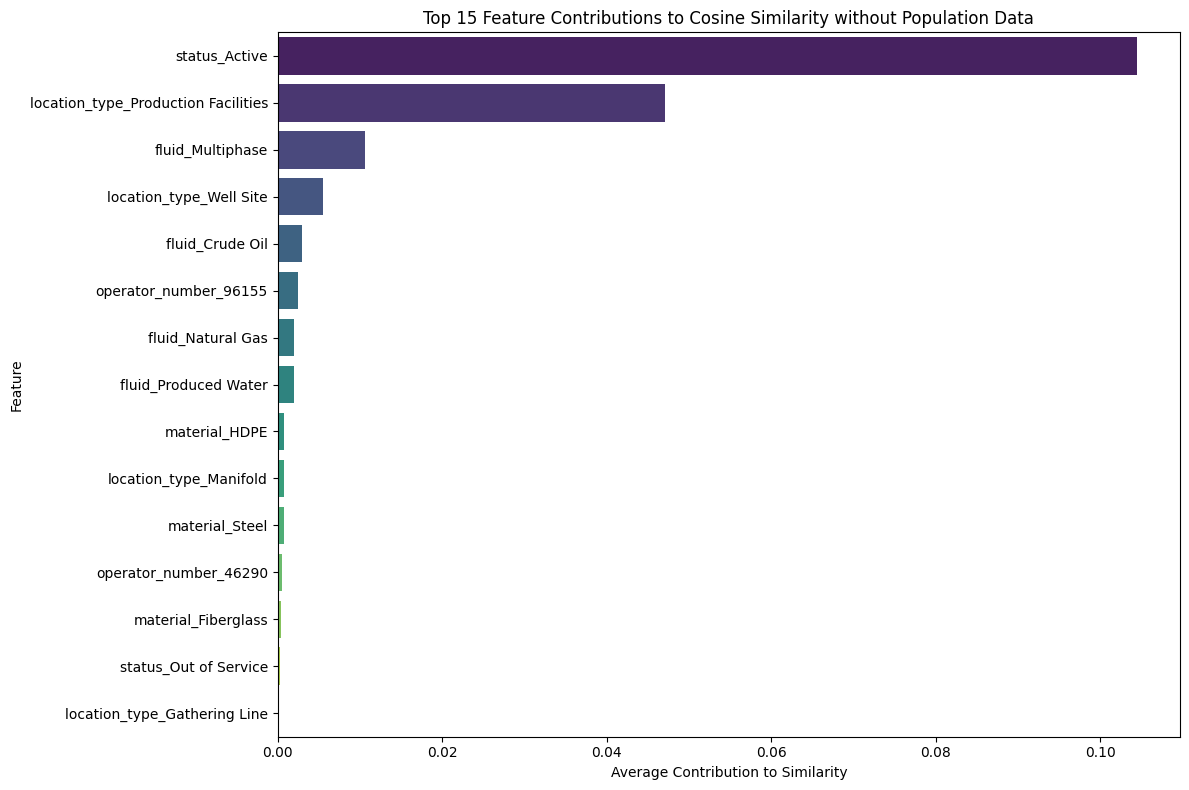

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the top 15 features contributing to similarity
plt.figure(figsize=(12, 8))
sns.barplot(
    x='AverageContribution',
    y='Feature',
    data=feature_contributions_df.head(15),
    palette='viridis'
)
plt.title('Top 15 Feature Contributions to Cosine Similarity without Population Data')
plt.xlabel('Average Contribution to Similarity')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Extreme Value Theory

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import genextreme

In [26]:
def plot_distribution_with_threshold(values, threshold):
    """
    Plots the distribution of 'values' with a vertical line indicating 'threshold'.
    """
    plt.figure(figsize=(8,5))
    sns.histplot(values, kde=True, stat='density')
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
    plt.title('Distribution of Spill Risk with Threshold')
    plt.xlabel('Spill Risk')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [19]:
def fit_gev(train_data, threshold_quantile=0.95):
    """
    Fits a GEV distribution to 'train_data' above the specified
    quantile threshold (default: 95th percentile).
    Returns: (shape, loc, scale, threshold_value)
    """
    # 1) Determine threshold
    threshold_value = np.quantile(train_data, threshold_quantile)
    # 2) Extract extreme values from train_data
    train_extremes = train_data[train_data > threshold_value]
    
    if len(train_extremes) < 5:
        # Not enough data to do a reliable fit
        return None, None, None, threshold_value

    # 3) Fit the GEV distribution to these extremes
    shape, loc, scale = genextreme.fit(train_extremes)
    return shape, loc, scale, threshold_value


In [20]:
def compute_r2_qq(empirical_data, shape, loc, scale):
    """
    Given empirical_data (already filtered to extremes), and GEV params,
    compute the R^2 comparing empirical vs. theoretical quantiles.
    """
    if len(empirical_data) < 2:
        return None  # Can't compute R^2 with 1 or 0 data points

    sorted_empirical = np.sort(empirical_data)
    n = len(sorted_empirical)
    # Probabilities (plotting positions)
    p = (np.arange(1, n + 1) - 0.5) / n
    # Theoretical quantiles from GEV
    theoretical_q = genextreme.ppf(p, shape, loc=loc, scale=scale)

    # R^2
    r2_val = r2_score(sorted_empirical, theoretical_q)
    return r2_val

In [35]:
def plot_qq(empirical_data, shape, loc, scale, title='', alpha=0.5):
    """
    Plots Q–Q of 'empirical_data' vs. GEV(shape, loc, scale).
    """
    sorted_empirical = np.sort(test_extremes)
    n = len(sorted_empirical)
    p = (np.arange(1, n + 1) - 0.5) / n
    theo_q = genextreme.ppf(p, shape, loc=loc, scale=scale)

    # Plot
    plt.figure(figsize=(6,5))
    plt.scatter(theoretical_q, sorted_empirical, alpha=alpha, label='Test Data Extremes')
    
    # 1:1 line
    q_min = min(theoretical_q.min(), sorted_empirical.min())
    q_max = max(theoretical_q.max(), sorted_empirical.max())
    plt.plot([q_min, q_max], [q_min, q_max], 'r--', label='45° line')
    
    plt.xlabel('Theoretical Quantiles (GEV)')
    plt.ylabel('Empirical Quantiles')
    plt.title(title)
    plt.legend()
    plt.show()

In [29]:
def plot_empirical_vs_gev_cdf(extreme_values, shape, loc, scale, title=''):
    # Sort the extreme values
    sorted_extremes = np.sort(extreme_values)
    n = len(sorted_extremes)
    
    # Empirical CDF: plotting position (i / (N+1))
    empirical_cdf = np.arange(1, n + 1) / (n + 1)
    
    # Theoretical (GEV) CDF evaluated at sorted extremes
    from scipy.stats import genextreme
    gev_cdf = genextreme.cdf(sorted_extremes, shape, loc=loc, scale=scale)
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(sorted_extremes, empirical_cdf, marker='o', linestyle='none', label='Empirical CDF')
    plt.plot(sorted_extremes, gev_cdf, color='red', label='Fitted GEV CDF')
    
    plt.title(title if title else 'Empirical vs. Fitted GEV CDF (Extreme Values)')
    plt.xlabel('Spill Risk (Extreme Only)')
    plt.ylabel('CDF')
    plt.legend()
    plt.show()

In [ ]:
if __name__ == '__main__':
    np.random.seed(42)
    data = gdf_result['risk_probability'].values  # original data
    
    # -- We only do this distribution plot once --
    threshold_quantile = 0.95
    global_threshold = np.quantile(data, threshold_quantile)
    plot_distribution_with_threshold(data, global_threshold)
    
    # Now proceed with the train–test splits
    test_sizes = [0.2, 0.15, 0.1]
    results = []

    for test_size in test_sizes:
        print(f"\n===============================")
        print(f" Train–Test Split = {1-test_size:.0%}/{test_size:.0%}")
        print(f"===============================")

        # 1) Split data
        train_values, test_values = train_test_split(
            data, 
            test_size=test_size, 
            random_state=42
        )

        # 3) Fit GEV on train extremes
        shape, loc, scale, thresh = fit_gev(train_values, threshold_quantile=0.95)
        if shape is None:
            print("Not enough extremes to fit GEV.")
            continue
        
        print(f"Fitted GEV Parameters:\n  Shape = {shape:.4f}\n  Loc   = {loc:.4f}\n  Scale = {scale:.4f}\n  Threshold = {thresh:.4f}")

        # 4) Evaluate on test data (above same threshold)
        test_extremes = test_values[test_values > thresh]
        if len(test_extremes) == 0:
            print("No test extremes above threshold. R^2 cannot be computed.")
            results.append({
                'TrainSize': 1 - test_size,
                'TestSize': test_size,
                'Shape': shape,
                'Loc': loc,
                'Scale': scale,
                'R^2': None,
                'NumTestExceed': 0
            })
            continue

        # 5) Q–Q Plot on test extremes
        r2_val = compute_r2_qq(test_extremes, shape, loc, scale)
        print(f"Test R^2 for extremes above threshold: {r2_val:.4f}" if r2_val else "R^2 not computed.")
        
        plot_title = f"Q–Q Plot | Split={1-test_size:.0%}/{test_size:.0%} | R^2={r2_val:.4f}"
        plot_qq(test_extremes, shape, loc, scale, title=plot_title)

        # 4a) CDF Plot on test extremes (in a separate cell or separate step)
        cdf_plot_title = f"CDF Plot | Split={1-test_size:.0%}/{test_size:.0%}"
        plot_empirical_vs_gev_cdf(test_extremes, shape, loc, scale, title=cdf_plot_title)
        
        # 6) Store results
        results.append({
            'TrainSize': 1 - test_size,
            'TestSize': test_size,
            'Shape': shape,
            'Loc': loc,
            'Scale': scale,
            'R^2': r2_val,
            'NumTestExceed': len(test_extremes)
        })

    # ------------------------------------------------------------------------
    # C) Summarize your results in a DataFrame
    # ------------------------------------------------------------------------
    results_df = pd.DataFrame(results)
    print("\nSummary of results across different splits:")
    print(results_df)

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genextreme
from sklearn.metrics import r2_score


def fit_gev(train_data, threshold_quantile=0.95):
    """
    Fits a GEV distribution to 'train_data' above the specified
    quantile threshold (default: 95th percentile).
    Returns: (shape, loc, scale, threshold_value)
    """
    threshold_value = np.quantile(train_data, threshold_quantile)
    train_extremes = train_data[train_data > threshold_value]
    
    if len(train_extremes) < 5:
        # Not enough data to do a reliable fit
        return None, None, None, threshold_value

    shape, loc, scale = genextreme.fit(train_extremes)
    return shape, loc, scale, threshold_value


def compute_r2_qq(empirical_data, shape, loc, scale):
    """
    Given 'empirical_data' (already filtered to extremes) and GEV params,
    compute R^2 comparing empirical vs. theoretical quantiles in a Q–Q context.
    """
    if len(empirical_data) < 2:
        return None  # Can't compute R^2 with <2 points
    
    sorted_empirical = np.sort(empirical_data)
    n = len(sorted_empirical)
    p = (np.arange(1, n + 1) - 0.5) / n  # plotting positions
    theoretical_q = genextreme.ppf(p, shape, loc=loc, scale=scale)

    r2_val = r2_score(sorted_empirical, theoretical_q)
    return r2_val


def plot_qq(empirical_extremes, shape, loc, scale, title='', alpha=0.5):
    """
    Plots a Q–Q comparison of 'empirical_extremes' vs. GEV(shape, loc, scale).
    """
    sorted_empirical = np.sort(empirical_extremes)
    n = len(sorted_empirical)
    p = (np.arange(1, n + 1) - 0.5) / n
    theoretical_q = genextreme.ppf(p, shape, loc=loc, scale=scale)

    plt.figure(figsize=(6,5))
    plt.scatter(theoretical_q, sorted_empirical, alpha=alpha, label='Test Data Extremes')
    
    # 45-degree line
    q_min = min(theoretical_q.min(), sorted_empirical.min())
    q_max = max(theoretical_q.max(), sorted_empirical.max())
    plt.plot([q_min, q_max], [q_min, q_max], 'r--', label='45° line')
    
    plt.xlabel('Theoretical Quantiles (GEV)')
    plt.ylabel('Empirical Quantiles')
    plt.title(title)
    plt.legend()
    plt.show()


def plot_empirical_vs_gev_cdf(extreme_values, shape, loc, scale, title=''):
    """
    Plots the Empirical CDF of 'extreme_values' and compares it to
    the fitted GEV CDF. Ensures we pass the same data subset used for Q–Q.
    """
    sorted_extremes = np.sort(extreme_values)
    n = len(sorted_extremes)
    
    # Empirical CDF using (i / (n+1)) positions
    empirical_cdf = np.arange(1, n + 1) / (n + 1)
    
    # Theoretical (GEV) CDF evaluated at sorted extremes
    gev_cdf = genextreme.cdf(sorted_extremes, shape, loc=loc, scale=scale)
    
    plt.figure(figsize=(8,5))
    plt.plot(sorted_extremes, empirical_cdf, marker='o', linestyle='none', label='Empirical CDF')
    plt.plot(sorted_extremes, gev_cdf, color='red', label='Fitted GEV CDF')
    
    plt.title(title if title else 'Empirical vs. Fitted GEV CDF (Extreme Values)')
    plt.xlabel('Spill Risk (Extreme Only)')
    plt.ylabel('CDF')
    plt.legend()
    plt.show()


def debug_gev_fit(train_data, test_data, shape, loc, scale, threshold):
    """
    Performs checks (debugging tests) on the fitted GEV parameters
    and data distribution:
      1) Whether threshold is too close to max(train_data) or max(test_data).
      2) Whether shape is positive or negative (and if data might be bounded).
      3) Number of extremes in train/test above threshold.
    """
    # 1. Threshold check
    max_train = train_data.max()
    max_test = test_data.max()
    if threshold >= max_train:
        print(f"[DEBUG WARNING] Threshold ({threshold:.4f}) >= max TRAIN value ({max_train:.4f}).")
    if threshold >= max_test:
        print(f"[DEBUG WARNING] Threshold ({threshold:.4f}) >= max TEST value ({max_test:.4f}).")
    
    # 2. Shape check: if shape > 0, the GEV tail is unbounded above.
    #    If data is strictly in [0,1], this might be suspicious.
    if shape > 0 and max_train <= 1.0 and max_test <= 1.0:
        print("[DEBUG WARNING] shape > 0 but data are all <= 1.0. Possibly a mismatch for a GEV with unbounded tail.")
    if shape < 0:
        print("[DEBUG INFO] shape < 0 => GEV with finite upper bound. Check if that matches your data domain.")
    
    # 3. Number of extremes
    train_extremes = train_data[train_data > threshold]
    test_extremes = test_data[test_data > threshold]
    print(f"[DEBUG INFO] # of TRAIN extremes above threshold: {len(train_extremes)}")
    print(f"[DEBUG INFO] # of TEST extremes above threshold:  {len(test_extremes)}")
    if len(train_extremes) < 5:
        print("[DEBUG WARNING] Fewer than 5 train extremes => GEV fit may be unreliable.")
    if len(test_extremes) < 5:
        print("[DEBUG WARNING] Fewer than 5 test extremes => Q–Q or CDF plot can be highly variable.")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

if __name__ == '__main__':
    # A) Prepare data (example: from your gdf_result)
    data = gdf_result['risk_probability'].values

    # B) Decide on your train-test splits and threshold
    test_sizes = [0.2, 0.15, 0.1]   # e.g. 80/20, 85/15, 90/10
    threshold_quantile = 0.95      # 95th percentile
    results = []

    # C) Loop over each train-test split
    for test_size in test_sizes:
        print(f"\n===============================")
        print(f" Train–Test Split = {1 - test_size:.0%}/{test_size:.0%}")
        print(f"===============================")
        
        # 1) Split data
        train_values, test_values = train_test_split(
            data,
            test_size=test_size,
            random_state=42
        )
        
        # 2) Fit GEV on train extremes
        shape, loc, scale, thresh = fit_gev(train_values, threshold_quantile)
        if shape is None:
            print("Not enough extremes to fit GEV.")
            continue
        
        print(f"Fitted GEV Parameters:")
        print(f"  Shape     = {shape:.4f}")
        print(f"  Loc       = {loc:.4f}")
        print(f"  Scale     = {scale:.4f}")
        print(f"  Threshold = {thresh:.4f}")

        # 2a) Debug checks
        debug_gev_fit(train_values, test_values, shape, loc, scale, thresh)
        
        # 3) Filter test extremes using the *training* threshold
        test_extremes = test_values[test_values > thresh]
        
        # If no extremes above threshold in test set, skip
        if len(test_extremes) == 0:
            print("No test extremes above threshold. R^2 cannot be computed.")
            results.append({
                'TrainSize': 1 - test_size,
                'TestSize': test_size,
                'Shape': shape,
                'Loc': loc,
                'Scale': scale,
                'R^2': None,
                'NumTestExceed': 0
            })
            continue
        
        # 4a) Compute R^2 on Q–Q
        r2_val = compute_r2_qq(test_extremes, shape, loc, scale)
        print(f"Test R^2 for extremes above threshold: {r2_val:.4f}"
              if r2_val is not None else "R^2 not computed.")
        
        # 4b) Q–Q Plot for test extremes
        qq_title = f"Q–Q Plot | Split={1-test_size:.0%}/{test_size:.0%} | R^2={r2_val:.4f}"
        plot_qq(test_extremes, shape, loc, scale, title=qq_title)
        
        # 4c) Empirical vs GEV CDF plot for test extremes
        cdf_title = f"CDF Plot | Split={1-test_size:.0%}/{test_size:.0%}"
        plot_empirical_vs_gev_cdf(test_extremes, shape, loc, scale, title=cdf_title)
        
        # 5) Store results
        results.append({
            'TrainSize': 1 - test_size,
            'TestSize': test_size,
            'Shape': shape,
            'Loc': loc,
            'Scale': scale,
            'R^2': r2_val,
            'NumTestExceed': len(test_extremes)
        })
    
    # D) Summarize
    results_df = pd.DataFrame(results)
    print("\nSummary of results across different splits:")
    print(results_df)


 Train–Test Split = 80%/20%
Fitted GEV Parameters:
  Shape     = -0.4044
  Loc       = 0.8890
  Scale     = 0.0171
  Threshold = 0.8736
[DEBUG INFO] shape < 0 => GEV with finite upper bound. Check if that matches your data domain.
[DEBUG INFO] # of TRAIN extremes above threshold: 10378
[DEBUG INFO] # of TEST extremes above threshold:  2535
[INFO] Negative shape => GEV finite upper bound ~ 0.9313


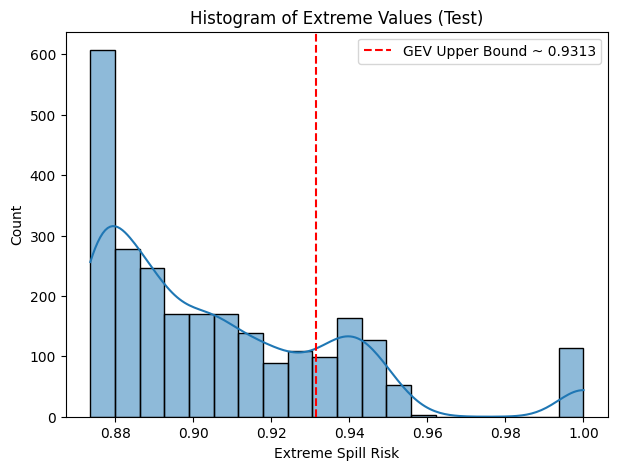

Test R^2 for extremes above threshold: -0.5424


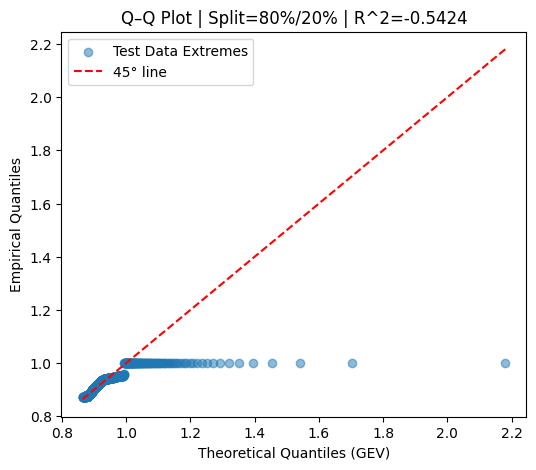

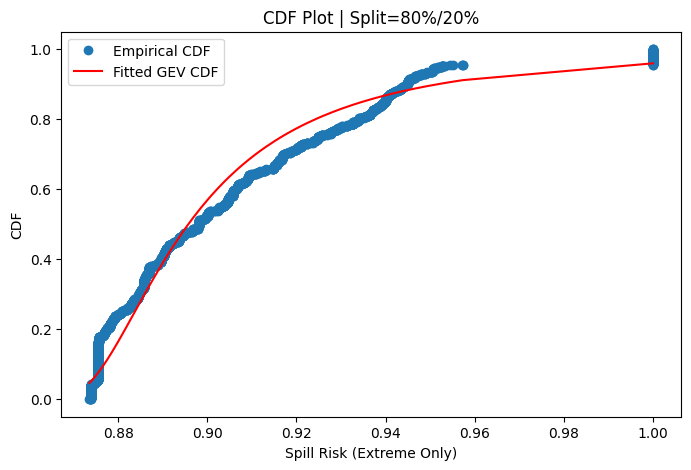


 Train–Test Split = 85%/15%
Fitted GEV Parameters:
  Shape     = -0.4087
  Loc       = 0.8889
  Scale     = 0.0171
  Threshold = 0.8736
[DEBUG INFO] shape < 0 => GEV with finite upper bound. Check if that matches your data domain.
[DEBUG INFO] # of TRAIN extremes above threshold: 10996
[DEBUG INFO] # of TEST extremes above threshold:  1917
[INFO] Negative shape => GEV finite upper bound ~ 0.9307


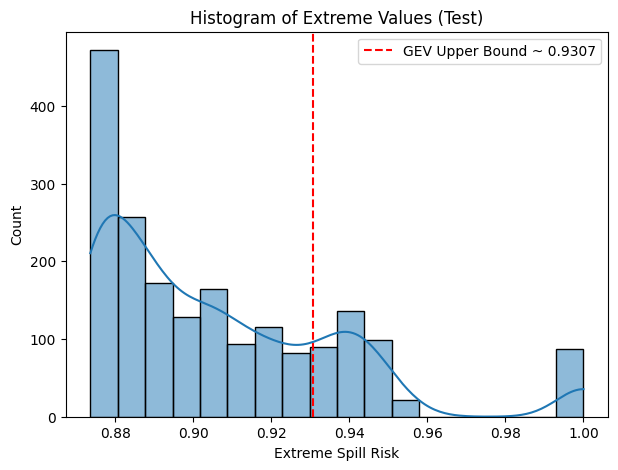

Test R^2 for extremes above threshold: -0.5273


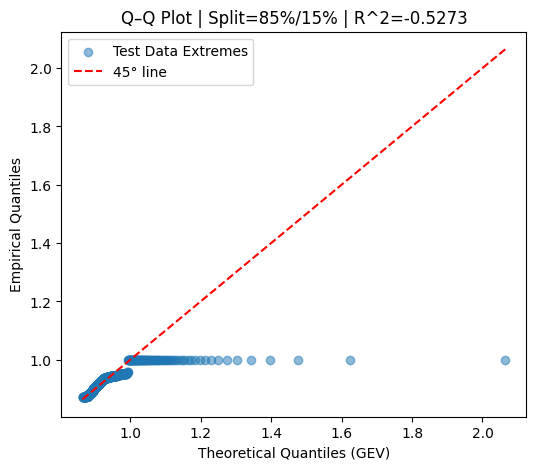

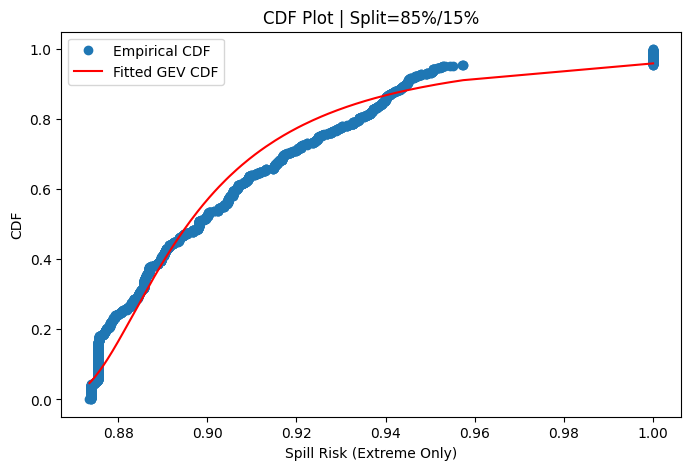


 Train–Test Split = 90%/10%
Fitted GEV Parameters:
  Shape     = -0.4180
  Loc       = 0.8888
  Scale     = 0.0170
  Threshold = 0.8736
[DEBUG INFO] shape < 0 => GEV with finite upper bound. Check if that matches your data domain.
[DEBUG INFO] # of TRAIN extremes above threshold: 11596
[DEBUG INFO] # of TEST extremes above threshold:  1317
[INFO] Negative shape => GEV finite upper bound ~ 0.9295


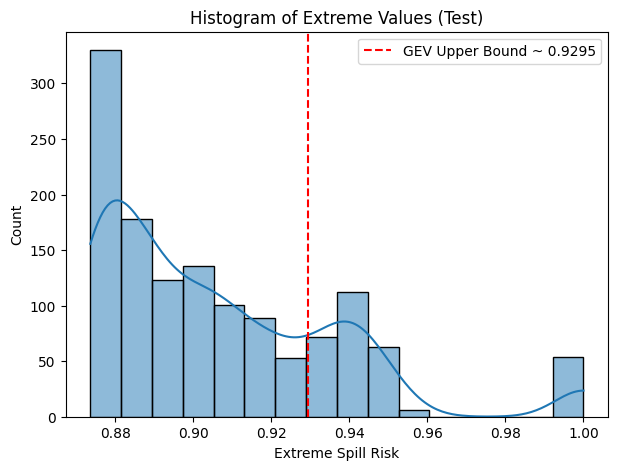

Test R^2 for extremes above threshold: -0.6543


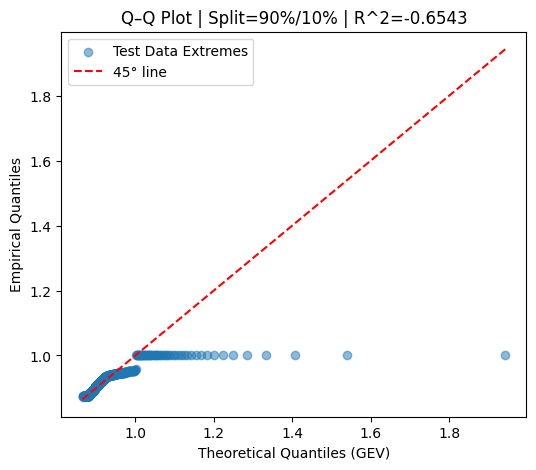

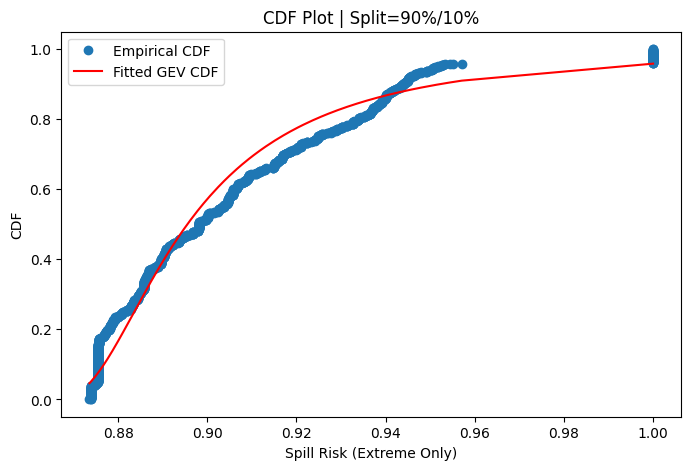


Summary of results across different splits:
   TrainSize  TestSize     Shape       Loc     Scale       R^2  NumTestExceed
0       0.80      0.20 -0.404409  0.888987  0.017118 -0.542437           2535
1       0.85      0.15 -0.408697  0.888926  0.017072 -0.527350           1917
2       0.90      0.10 -0.417987  0.888806  0.017012 -0.654266           1317

[OPTIONAL] Testing multiple thresholds with the final train/test split.
Threshold 0.9: #TrainExt=24768, #TestExt=2790, R^2=-18.463966587580455
Threshold 0.95: #TrainExt=11596, #TestExt=1317, R^2=-0.6542663607394348
Threshold 0.975: #TrainExt=6193, #TestExt=698, R^2=0.6427264319879213
Threshold 0.99: #TrainExt=2457, #TestExt=285, R^2=-4.740938394999153

[OPTIONAL] Beta Fit: alpha=0.617, beta=0.962
Plotting Beta Q–Q for entire test set (just as a comparison).


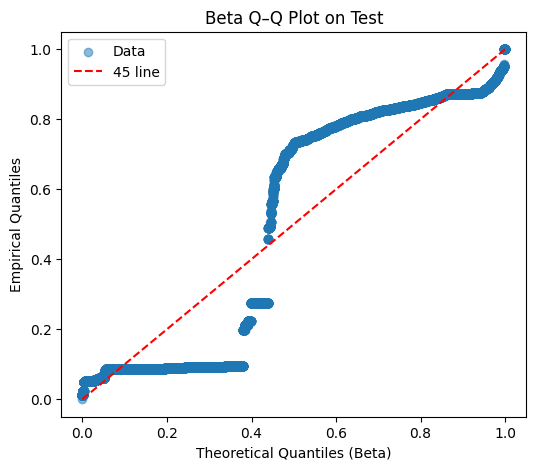

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genextreme, beta
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

#############################################################################
# 1. GEV-Related Helper Functions
#############################################################################

def fit_gev(train_data, threshold_quantile=0.95):
    """
    Fits a GEV distribution to 'train_data' above the specified
    quantile threshold (default: 95th percentile).
    Returns: (shape, loc, scale, threshold_value)
    """
    threshold_value = np.quantile(train_data, threshold_quantile)
    train_extremes = train_data[train_data > threshold_value]
    
    if len(train_extremes) < 5:
        # Not enough data to do a reliable fit
        return None, None, None, threshold_value

    shape, loc, scale = genextreme.fit(train_extremes)
    return shape, loc, scale, threshold_value


def compute_r2_qq(empirical_data, shape, loc, scale):
    """
    Given 'empirical_data' (already filtered to extremes) and GEV params,
    compute R^2 comparing empirical vs. theoretical quantiles in a Q–Q context.
    """
    if len(empirical_data) < 2:
        return None  # Can't compute R^2 with <2 points
    
    sorted_empirical = np.sort(empirical_data)
    n = len(sorted_empirical)
    p = (np.arange(1, n + 1) - 0.5) / n  # plotting positions
    theoretical_q = genextreme.ppf(p, shape, loc=loc, scale=scale)

    r2_val = r2_score(sorted_empirical, theoretical_q)
    return r2_val


def plot_qq(empirical_extremes, shape, loc, scale, title='', alpha=0.5):
    """
    Plots a Q–Q comparison of 'empirical_extremes' vs. GEV(shape, loc, scale).
    """
    sorted_empirical = np.sort(empirical_extremes)
    n = len(sorted_empirical)
    p = (np.arange(1, n + 1) - 0.5) / n
    theoretical_q = genextreme.ppf(p, shape, loc=loc, scale=scale)

    plt.figure(figsize=(6,5))
    plt.scatter(theoretical_q, sorted_empirical, alpha=alpha, label='Test Data Extremes')
    
    # 45-degree line
    q_min = min(theoretical_q.min(), sorted_empirical.min())
    q_max = max(theoretical_q.max(), sorted_empirical.max())
    plt.plot([q_min, q_max], [q_min, q_max], 'r--', label='45° line')
    
    plt.xlabel('Theoretical Quantiles (GEV)')
    plt.ylabel('Empirical Quantiles')
    plt.title(title)
    plt.legend()
    plt.show()


def plot_empirical_vs_gev_cdf(extreme_values, shape, loc, scale, title=''):
    """
    Plots the Empirical CDF of 'extreme_values' and compares it to
    the fitted GEV CDF. Ensures we pass the same data subset used for Q–Q.
    """
    sorted_extremes = np.sort(extreme_values)
    n = len(sorted_extremes)
    
    # Empirical CDF using (i / (n+1)) positions
    empirical_cdf = np.arange(1, n + 1) / (n + 1)
    
    # Theoretical (GEV) CDF evaluated at sorted_extremes
    gev_cdf = genextreme.cdf(sorted_extremes, shape, loc=loc, scale=scale)
    
    plt.figure(figsize=(8,5))
    plt.plot(sorted_extremes, empirical_cdf, marker='o', linestyle='none', label='Empirical CDF')
    plt.plot(sorted_extremes, gev_cdf, color='red', label='Fitted GEV CDF')
    
    plt.title(title if title else 'Empirical vs. Fitted GEV CDF (Extreme Values)')
    plt.xlabel('Spill Risk (Extreme Only)')
    plt.ylabel('CDF')
    plt.legend()
    plt.show()


def debug_gev_fit(train_data, test_data, shape, loc, scale, threshold):
    """
    Performs checks (debugging tests) on the fitted GEV parameters
    and data distribution:
      1) Whether threshold is too close to max(train_data) or max(test_data).
      2) Whether shape is positive or negative (and if data might be bounded).
      3) Number of extremes in train/test above threshold.
    """
    max_train = train_data.max()
    max_test = test_data.max()
    if threshold >= max_train:
        print(f"[DEBUG WARNING] Threshold ({threshold:.4f}) >= max TRAIN value ({max_train:.4f}).")
    if threshold >= max_test:
        print(f"[DEBUG WARNING] Threshold ({threshold:.4f}) >= max TEST value ({max_test:.4f}).")
    
    if shape > 0 and max_train <= 1.0 and max_test <= 1.0:
        print("[DEBUG WARNING] shape > 0 but data are all <= 1.0. Possibly a mismatch for a GEV with unbounded tail.")
    if shape < 0:
        print("[DEBUG INFO] shape < 0 => GEV with finite upper bound. Check if that matches your data domain.")
    
    train_extremes = train_data[train_data > threshold]
    test_extremes = test_data[test_data > threshold]
    print(f"[DEBUG INFO] # of TRAIN extremes above threshold: {len(train_extremes)}")
    print(f"[DEBUG INFO] # of TEST extremes above threshold:  {len(test_extremes)}")
    if len(train_extremes) < 5:
        print("[DEBUG WARNING] Fewer than 5 train extremes => GEV fit may be unreliable.")
    if len(test_extremes) < 5:
        print("[DEBUG WARNING] Fewer than 5 test extremes => Q–Q or CDF plot can be highly variable.")


#############################################################################
# 2. Additional Diagnostics / Alternative Distributions
#############################################################################

def check_gev_upper_bound(shape, loc, scale):
    """
    If shape < 0, compute and print the implied finite upper bound (Loc - Scale/Shape).
    Returns that value or None otherwise.
    """
    if shape < 0:
        ub = loc - (scale / shape)
        print(f"[INFO] Negative shape => GEV finite upper bound ~ {ub:.4f}")
        return ub
    else:
        print("[INFO] shape >= 0 => GEV has no finite upper bound.")
        return None


def plot_tail_histogram(extreme_values, upper_bound=None):
    """
    Plots a simple histogram/KDE for the extreme values. Optionally draws
    a vertical line at 'upper_bound' if shape < 0 was found.
    """
    plt.figure(figsize=(7,5))
    sns.histplot(extreme_values, kde=True)
    plt.title("Histogram of Extreme Values (Test)")
    plt.xlabel("Extreme Spill Risk")
    plt.ylabel("Count")

    if upper_bound is not None:
        plt.axvline(upper_bound, color='red', linestyle='--',
                    label=f"GEV Upper Bound ~ {upper_bound:.4f}")
        plt.legend()
    plt.show()


def fit_beta(data):
    """
    If data are strictly in [0,1], attempt to fit a Beta distribution.
    Returns (alpha, beta) or (None,None) if not enough data.
    """
    data_in_01 = data[(data > 0) & (data < 1)]
    if len(data_in_01) < 2:
        return None, None
    # Fit beta with loc=0, scale=1 fixed
    alpha_hat, beta_hat, _, _ = beta.fit(data_in_01, floc=0, fscale=1)
    return alpha_hat, beta_hat


def qq_beta_plot(data, alpha_hat, beta_hat, title='Beta Q–Q'):
    """
    Q–Q plot comparing 'data' with Beta(alpha_hat, beta_hat).
    """
    data_sorted = np.sort(data)
    n = len(data_sorted)
    p = (np.arange(1, n+1) - 0.5)/n
    theo_q = beta.ppf(p, alpha_hat, beta_hat)

    plt.figure(figsize=(6,5))
    plt.scatter(theo_q, data_sorted, alpha=0.5, label='Data')
    min_val = min(theo_q.min(), data_sorted.min())
    max_val = max(theo_q.max(), data_sorted.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='45 line')
    plt.title(title)
    plt.xlabel("Theoretical Quantiles (Beta)")
    plt.ylabel("Empirical Quantiles")
    plt.legend()
    plt.show()


#############################################################################
# 3. Main Implementation
#############################################################################

if __name__ == '__main__':
    # Example data: from your gdf_result
    # (Replace 'gdf_result' with your actual DataFrame or array)
    data = gdf_result['risk_probability'].values

    # 3A) Decide on your train-test splits and threshold
    test_sizes = [0.2, 0.15, 0.1]   # e.g. 80/20, 85/15, 90/10
    threshold_quantile = 0.95      # 95th percentile
    results = []

    # 3B) Loop over each train-test split
    for test_size in test_sizes:
        print(f"\n===============================")
        print(f" Train–Test Split = {1 - test_size:.0%}/{test_size:.0%}")
        print(f"===============================")
        
        # 1) Split data
        train_values, test_values = train_test_split(
            data,
            test_size=test_size,
            random_state=42
        )
        
        # 2) Fit GEV on train extremes
        shape, loc, scale, thresh = fit_gev(train_values, threshold_quantile)
        if shape is None:
            print("Not enough extremes to fit GEV.")
            continue
        
        print(f"Fitted GEV Parameters:")
        print(f"  Shape     = {shape:.4f}")
        print(f"  Loc       = {loc:.4f}")
        print(f"  Scale     = {scale:.4f}")
        print(f"  Threshold = {thresh:.4f}")

        # 2a) Debug checks
        debug_gev_fit(train_values, test_values, shape, loc, scale, thresh)
        
        # 2b) Check the implied upper bound if shape < 0
        ub = check_gev_upper_bound(shape, loc, scale)

        # 3) Filter test extremes using the *training* threshold
        test_extremes = test_values[test_values > thresh]
        
        # If no extremes above threshold in test set, skip
        if len(test_extremes) == 0:
            print("No test extremes above threshold. R^2 cannot be computed.")
            results.append({
                'TrainSize': 1 - test_size,
                'TestSize': test_size,
                'Shape': shape,
                'Loc': loc,
                'Scale': scale,
                'R^2': None,
                'NumTestExceed': 0
            })
            continue
        
        # (Optional) Plot the distribution of test extremes vs. GEV upper bound
        plot_tail_histogram(test_extremes, upper_bound=ub)

        # 4a) Compute R^2 on Q–Q
        r2_val = compute_r2_qq(test_extremes, shape, loc, scale)
        print(f"Test R^2 for extremes above threshold: {r2_val:.4f}"
              if r2_val is not None else "R^2 not computed.")
        
        # 4b) Q–Q Plot for test extremes
        qq_title = f"Q–Q Plot | Split={1-test_size:.0%}/{test_size:.0%} | R^2={r2_val:.4f}"
        plot_qq(test_extremes, shape, loc, scale, title=qq_title)
        
        # 4c) Empirical vs GEV CDF plot for test extremes
        cdf_title = f"CDF Plot | Split={1-test_size:.0%}/{test_size:.0%}"
        plot_empirical_vs_gev_cdf(test_extremes, shape, loc, scale, title=cdf_title)
        
        # 5) Store results
        results.append({
            'TrainSize': 1 - test_size,
            'TestSize': test_size,
            'Shape': shape,
            'Loc': loc,
            'Scale': scale,
            'R^2': r2_val,
            'NumTestExceed': len(test_extremes)
        })
    
    # 3C) Summarize
    results_df = pd.DataFrame(results)
    print("\nSummary of results across different splits:")
    print(results_df)

    #########################################################################
    # 4. (Optional) Threshold Testing and Beta Example
    #########################################################################

    # Example: Try different thresholds to see if R^2 improves
    # (Using the same train/test from the last iteration, or choose one.)
    print("\n[OPTIONAL] Testing multiple thresholds with the final train/test split.")
    threshold_candidates = [0.90, 0.95, 0.975, 0.99]
    for tq in threshold_candidates:
        shape2, loc2, scale2, thresh2 = fit_gev(train_values, threshold_quantile=tq)
        if shape2 is None:
            print(f"Threshold {tq} => Not enough data to fit GEV.")
            continue

        test_ext2 = test_values[test_values > thresh2]
        r2_val2 = compute_r2_qq(test_ext2, shape2, loc2, scale2)
        print(f"Threshold {tq}: #TrainExt={sum(train_values>thresh2)}, #TestExt={len(test_ext2)}, R^2={r2_val2}")

    # Example: Fit a Beta distribution (only if data is strictly in [0,1])
    alpha_hat, beta_hat = fit_beta(train_values)
    if alpha_hat is not None:
        print(f"\n[OPTIONAL] Beta Fit: alpha={alpha_hat:.3f}, beta={beta_hat:.3f}")
        print("Plotting Beta Q–Q for entire test set (just as a comparison).")
        qq_beta_plot(test_values, alpha_hat, beta_hat, title="Beta Q–Q Plot on Test")
    else:
        print("\n[OPTIONAL] Could not fit Beta (data not in (0,1), or too few points).")



 Train–Test Split = 80%/20%
Fitted GEV Parameters:
  Shape     = -0.2667
  Loc       = 0.9144
  Scale     = 0.0160
  Threshold = 0.8969
[DEBUG INFO] shape < 0 => GEV with finite upper bound. Check if that matches your data domain.
[DEBUG INFO] # of TRAIN extremes above threshold: 5498
[DEBUG INFO] # of TEST extremes above threshold:  1303
[INFO] Negative shape => GEV finite upper bound ~ 0.9743


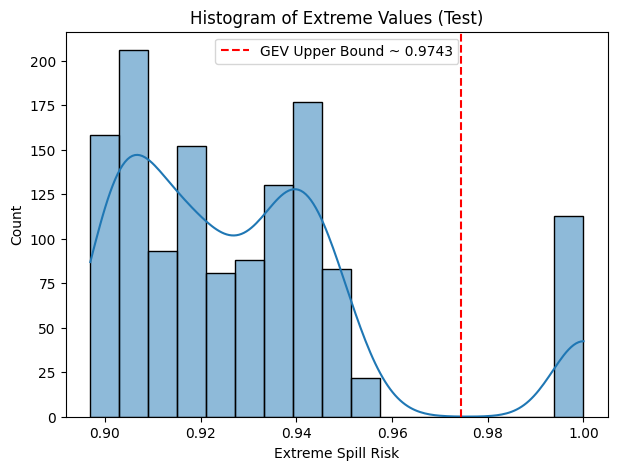

Test R^2 for extremes above threshold: 0.6167


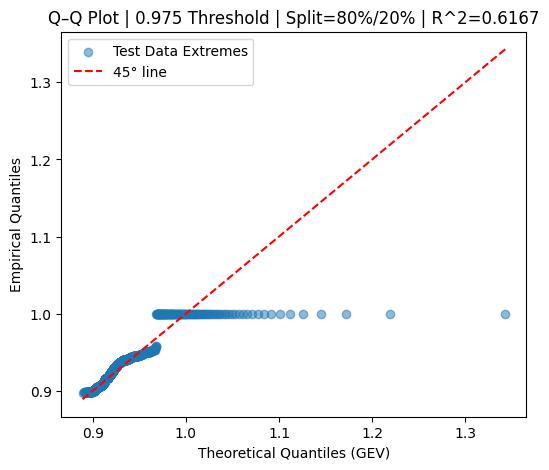

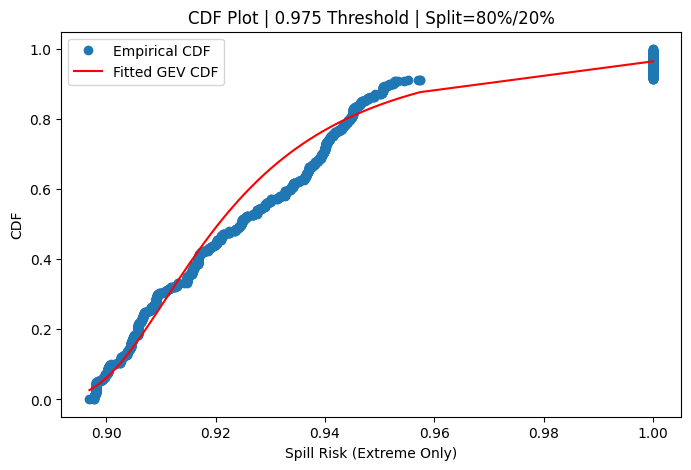


 Train–Test Split = 85%/15%
Fitted GEV Parameters:
  Shape     = -0.2644
  Loc       = 0.9144
  Scale     = 0.0160
  Threshold = 0.8969
[DEBUG INFO] shape < 0 => GEV with finite upper bound. Check if that matches your data domain.
[DEBUG INFO] # of TRAIN extremes above threshold: 5813
[DEBUG INFO] # of TEST extremes above threshold:  988
[INFO] Negative shape => GEV finite upper bound ~ 0.9751


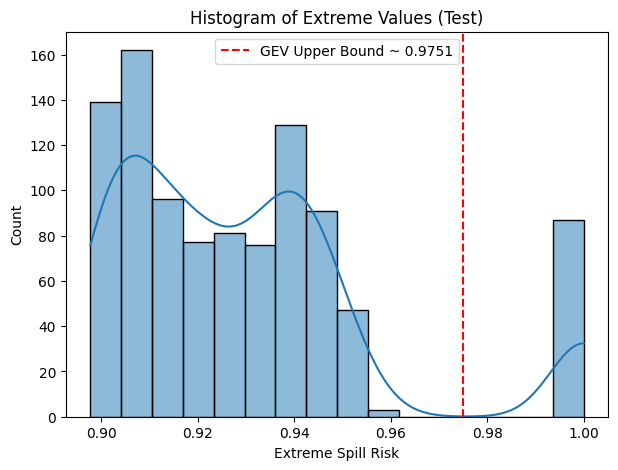

Test R^2 for extremes above threshold: 0.6379


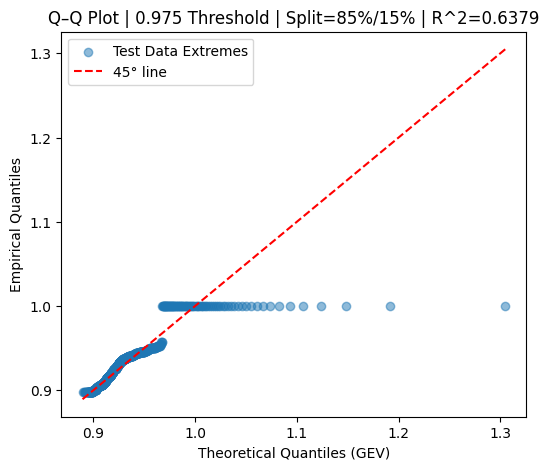

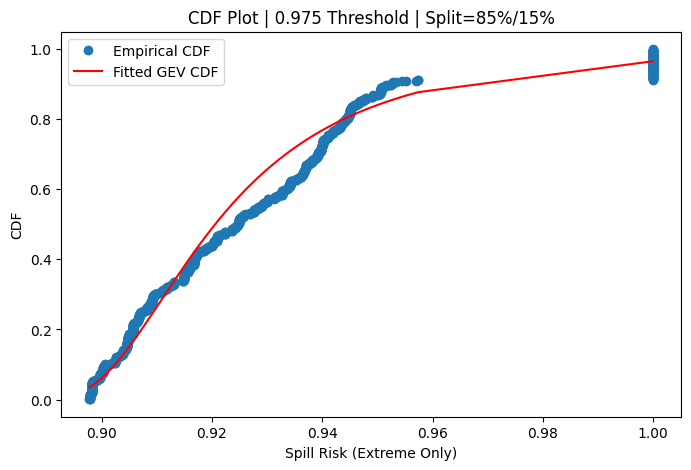


 Train–Test Split = 90%/10%
Fitted GEV Parameters:
  Shape     = -0.2641
  Loc       = 0.9141
  Scale     = 0.0162
  Threshold = 0.8961
[DEBUG INFO] shape < 0 => GEV with finite upper bound. Check if that matches your data domain.
[DEBUG INFO] # of TRAIN extremes above threshold: 6193
[DEBUG INFO] # of TEST extremes above threshold:  698
[INFO] Negative shape => GEV finite upper bound ~ 0.9753


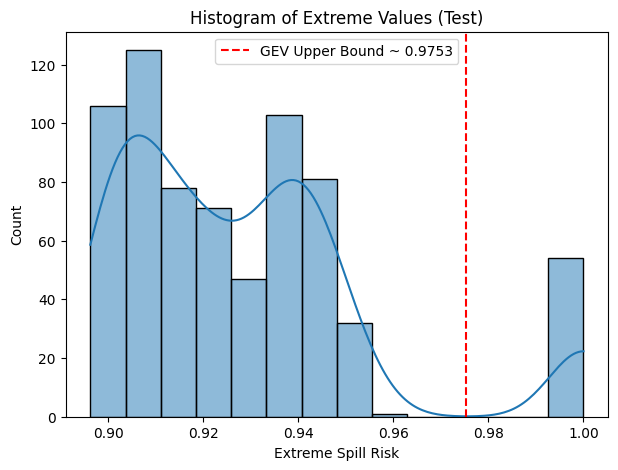

Test R^2 for extremes above threshold: 0.6427


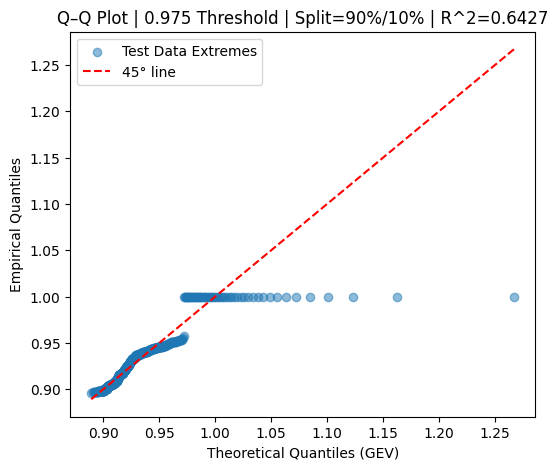

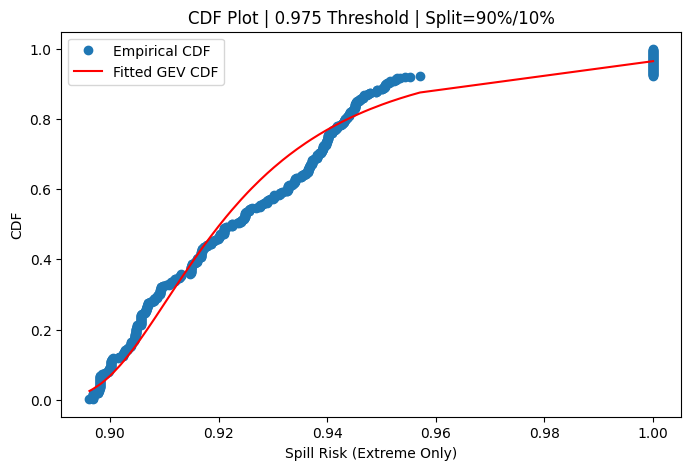


Summary of results with threshold=0.975:
   TrainSize  TestSize     Shape       Loc     Scale       R^2  NumTestExceed
0       0.80      0.20 -0.266730  0.914356  0.015992  0.616654           1303
1       0.85      0.15 -0.264437  0.914421  0.016035  0.637915            988
2       0.90      0.10 -0.264082  0.914083  0.016157  0.642726            698


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split

if __name__ == '__main__':
    data = gdf_result['risk_probability'].values

    # Use a single threshold that worked best in your tests
    threshold_quantile = 0.975  # 97.5%
    test_sizes = [0.2, 0.15, 0.1]
    results = []

    for test_size in test_sizes:
        print(f"\n===================================")
        print(f" Train–Test Split = {1 - test_size:.0%}/{test_size:.0%}")
        print(f"===================================")
        
        train_values, test_values = train_test_split(
            data, test_size=test_size, random_state=42
        )
        
        # Fit GEV on train extremes above the 97.5th percentile
        shape, loc, scale, thresh = fit_gev(train_values, threshold_quantile)
        if shape is None:
            print("Not enough extremes to fit GEV at threshold 0.975.")
            continue

        print(f"Fitted GEV Parameters:")
        print(f"  Shape     = {shape:.4f}")
        print(f"  Loc       = {loc:.4f}")
        print(f"  Scale     = {scale:.4f}")
        print(f"  Threshold = {thresh:.4f}")

        debug_gev_fit(train_values, test_values, shape, loc, scale, thresh)
        
        test_extremes = test_values[test_values > thresh]
        if len(test_extremes) == 0:
            print("No test extremes above threshold. R^2 cannot be computed.")
            results.append({
                'TrainSize': 1 - test_size,
                'TestSize': test_size,
                'Shape': shape,
                'Loc': loc,
                'Scale': scale,
                'R^2': None,
                'NumTestExceed': 0
            })
            continue
        
        # Optional: check GEV upper bound if shape<0
        ub = check_gev_upper_bound(shape, loc, scale)
        plot_tail_histogram(test_extremes, ub)

        # R^2 and plots
        r2_val = compute_r2_qq(test_extremes, shape, loc, scale)
        print(f"Test R^2 for extremes above threshold: {r2_val:.4f}"
              if r2_val is not None else "R^2 not computed.")

        qq_title = f"Q–Q Plot | 0.975 Threshold | Split={1-test_size:.0%}/{test_size:.0%} | R^2={r2_val:.4f}"
        plot_qq(test_extremes, shape, loc, scale, title=qq_title)

        cdf_title = f"CDF Plot | 0.975 Threshold | Split={1-test_size:.0%}/{test_size:.0%}"
        plot_empirical_vs_gev_cdf(test_extremes, shape, loc, scale, title=cdf_title)
        
        results.append({
            'TrainSize': 1 - test_size,
            'TestSize': test_size,
            'Shape': shape,
            'Loc': loc,
            'Scale': scale,
            'R^2': r2_val,
            'NumTestExceed': len(test_extremes)
        })
    
    results_df = pd.DataFrame(results)
    print("\nSummary of results with threshold=0.975:")
    print(results_df)


In [42]:
delta=10^(-10)
p=1-delta
log(p/(1-p))

NameError: name 'log' is not defined